In [192]:
%load_ext autoreload 
%autoreload 2
import numpy as np
import random
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')
from colossus.halo import concentration, mass_defs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from pylab import rcParams
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'
rcParams['font.family'] = 'serif'
rc('text.latex',preamble=r'\usepackage{/Volumes/Extreme_SSD/codes/master_thesis/code/configs/apjfonts}')
sz_ft = 20
sz_lb = 14
color_arr = ['indigo', 'royalblue', 'lightseagreen', 'darkgreen', 'goldenrod', 'darkred']
from tqdm import tqdm
import cosmo
import lensing_estimator
from cosmo import CosmoCalc
import lensing
import foregrounds as fg
import experiments as exp
import sims
import stats
import tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## General Settings, Background Stacks, and Covariance Matrices

In [ ]:
nber_clus = 3000
nber_rand = 50000
nber_cov = 1000
nber_runs = 25
map_params = [180, 0.5, 180, 0.5]
l, cl = CosmoCalc().cmb_power_spectrum()
l, bl = exp.beam_power_spectrum(beam_fwhm = 1.0)
noiseval_arr = [0.1, 0.25, 0.5, 1, 2, 3, 5]
nl_arr = []
cl_noise_arr = []
for noiseval in noiseval_arr:
    l, nl = exp.white_noise_power_spectrum(noiseval_white = noiseval)
    l, nl_deconvolved =exp.white_noise_power_spectrum(noiseval_white = noiseval, beam_fwhm = 1.0)
    nl_arr.append(nl)
    cl_noise_arr.append(nl_deconvolved)
z = 0.7

In [4]:
for i, noiseval in enumerate(noiseval_arr):
    maps_rand = sims.cmb_mock_data(map_params, l, cl,  bl = bl, nl = nl_arr[i], nber_obs = nber_rand)
    stack_bg = lensing_estimator.stack(map_params, maps_rand, l = l, cl = cl, cl_noise = cl_noise_arr[i])
    del maps_rand
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_'+str(noiseval)+'uK-arcmin.npy', stack_bg)   

In [ ]:
for i, noiseval in enumerate(noiseval_arr):
    covariance_matrix, _ = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl_arr[i], cl_noise = cl_noise_arr[i])
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_'+str(noiseval)+'uK-arcmin.npy', covariance_matrix)  

## Estimator Validation

In [194]:
cluster_2e14 = [2e14, cosmo.concentration_parameter(2e14, z, 0.674), z]
cluster_6e14 = [6e14, cosmo.concentration_parameter(6e14, z, 0.674), z]
cluster_10e14 = [10e14, cosmo.concentration_parameter(10e14, z, 0.674), z]
cluster_arr = [cluster_2e14, cluster_6e14, cluster_10e14]
mass_int = np.arange(0, 12, 0.1)

In [6]:
model_profiles_estimator_validation = lensing_estimator.model_profiles(nber_clus, map_params, l, cl, mass_int, z, bl = bl, cl_noise = cl_noise_arr[4])
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_estimator_validation.npy', model_profiles_estimator_validation)    

  0%|          | 0/3000 [00:00<?, ?it/s]/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:95: RuntimeWarning: invalid value encountered in double_scalars
  r_s = r_200/self.c_200
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:96: RuntimeWarning: invalid value encountered in double_scalars
  rho_s = (200 / 3) * rho_c * (self.c_200 ** 3 / (np.log(1 + self.c_200) - (self.c_200 / (1 + self.c_200))))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:117: RuntimeWarning: divide by zero encountered in arctanh
  f[x3] = (1/np.sqrt(1-x[x3]**2))*np.arctanh(np.sqrt(1-x[x3]**2))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:45: RuntimeWarning: invalid value encountered in true_divide
  alphaX_fft =  1j * lX * 2. *  kappa_map_fft / l2d**2
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:46: RuntimeWarning: invalid value encountered in true_divide
  alphaY_fft =  1j * lY * 2. *  kappa_map_fft / l2d**2
100%|██████████| 120/120 [00:01<00:00, 69.61it/s]


In [195]:
stack_bg = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_2uK-arcmin.npy')   
covariance_matrix = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy')  
model_profiles = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_estimator_validation.npy')    


lk_arr_2e14 = []      
lk_arr_6e14 = []  
lk_arr_10e14 = []  
for i in tqdm(range(nber_runs)):  
    maps_clus = sims.cmb_test_data(map_params, l, cl, cluster = cluster_arr, bl = bl, nl = nl_arr[4], nber_obs = nber_clus, estimator_validation = True)
    maps_clus_2e14, maps_clus_6e14, maps_clus_10e14 = maps_clus[0], maps_clus[1], maps_clus[2]
    stack_clus_2e14 = lensing_estimator.stack(map_params, maps_clus_2e14, l = l, cl = cl, cl_noise = cl_noise_arr[4])
    stack_clus_6e14 = lensing_estimator.stack(map_params, maps_clus_6e14, l = l, cl = cl, cl_noise = cl_noise_arr[4])
    stack_clus_10e14 = lensing_estimator.stack(map_params, maps_clus_10e14, l = l, cl = cl, cl_noise = cl_noise_arr[4])
    bins_2e14, lensing_dipole_profile_2e14, stack_dipole_2e14 = lensing_estimator.lensing_dipole(map_params, stack_clus_2e14, stack_bg)
    bins_6e14, lensing_dipole_profile_6e14, stack_dipole_6e14 = lensing_estimator.lensing_dipole(map_params, stack_clus_6e14, stack_bg)
    bins_10e14, lensing_dipole_profile_10e14, stack_dipole_10e14 = lensing_estimator.lensing_dipole(map_params, stack_clus_10e14, stack_bg)
    data_2e14 = bins_2e14, lensing_dipole_profile_2e14, covariance_matrix
    data_6e14 = bins_6e14, lensing_dipole_profile_6e14, covariance_matrix
    data_10e14 = bins_10e14, lensing_dipole_profile_10e14, covariance_matrix
   

    likelihood_2e14, _, _ = stats.run_ml(data_2e14, model_profiles, mass_int)
    mass_int_lk_2e14, lk_2e14 = likelihood_2e14
    likelihood_6e14, _, _ = stats.run_ml(data_6e14, model_profiles, mass_int)
    mass_int_lk_6e14, lk_6e14 = likelihood_6e14
    likelihood_10e14, _, _ = stats.run_ml(data_10e14, model_profiles, mass_int)
    mass_int_lk_10e14, lk_10e14 = likelihood_10e14
    lk_arr_2e14.append(lk_2e14)
    lk_arr_6e14.append(lk_6e14)
    lk_arr_10e14.append(lk_10e14)

    del maps_clus
    del maps_clus_2e14
    del maps_clus_6e14
    del maps_clus_10e14


lk_arr_estimator_validation = [lk_arr_2e14, lk_arr_6e14, lk_arr_10e14]
for i, mass in enumerate([2, 6, 10]):
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_'+str(mass)+'e14.npy', lk_arr_estimator_validation[i]) 
    
comb_lk_2e14, mass_value_comb_lk_2e14, error_comb_lk_2e14 = stats.combined_likelihood(mass_int_lk_2e14, lk_arr_2e14)      
comb_lk_6e14, mass_value_comb_lk_6e14, error_comb_lk_6e14 = stats.combined_likelihood(mass_int_lk_6e14, lk_arr_6e14)      
comb_lk_10e14, mass_value_comb_lk_10e14, error_comb_lk_10e14 = stats.combined_likelihood(mass_int_lk_10e14, lk_arr_10e14)      
comb_lk_arr_estimator_validation = [comb_lk_2e14, comb_lk_6e14, comb_lk_10e14]
for i, mass in enumerate([2, 6, 10]):
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/comb_lk_estimator_validation_'+str(mass)+'e14.npy', comb_lk_arr_estimator_validation[i]) 

mass_results_estimator_validation = "{0:11.3f}{1:>1}{2:5.3f}".format(mass_value_comb_lk_2e14, "+-", error_comb_lk_2e14) + "\n"
mass_results_estimator_validation += "{0:11.3f}{1:>1}{2:5.3f}".format(mass_value_comb_lk_6e14, "+-", error_comb_lk_6e14) + "\n"          
mass_results_estimator_validation += "{0:11.3f}{1:>1}{2:5.3f}".format(mass_value_comb_lk_10e14, "+-", error_comb_lk_10e14) + "\n"
file = open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_results_estimator_validation.txt',"w")
file.write(mass_results_estimator_validation)
file.close() 

  0%|          | 0/100 [00:00<?, ?it/s]/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:117: RuntimeWarning: divide by zero encountered in arctanh
  f[x3] = (1/np.sqrt(1-x[x3]**2))*np.arctanh(np.sqrt(1-x[x3]**2))
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:45: RuntimeWarning: invalid value encountered in true_divide
  alphaX_fft =  1j * lX * 2. *  kappa_map_fft / l2d**2
/Volumes/Extreme_SSD/codes/master_thesis/code/lensing.py:46: RuntimeWarning: invalid value encountered in true_divide
  alphaY_fft =  1j * lY * 2. *  kappa_map_fft / l2d**2
100%|██████████| 100/100 [5:05:25<00:00, 183.26s/it] 


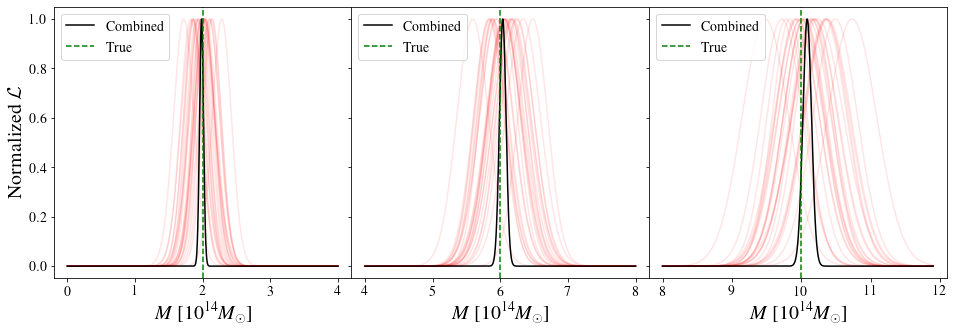

In [288]:
lk_arr_estimator_validation = []
for mass in [2, 6, 10]:
    lk = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/lk_arr_estimator_validation_'+str(mass)+'e14.npy') 
    lk_arr_estimator_validation.append(lk)

comb_lk_arr_estimator_validation = []
for mass in [2, 6, 10]:
    comb_lk = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/comb_lk_estimator_validation_'+str(mass)+'e14.npy')     
    comb_lk_arr_estimator_validation.append(comb_lk)
    
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(16,5))
(ax1, ax2, ax3) = axs

for i in range(nber_runs):
    ax1.plot(mass_int_lk_2e14[0:4000], lk_arr_estimator_validation[0][i][0:4000], color = 'red', ls='-', alpha = 0.1)
ax1.plot(mass_int_lk_2e14[0:4000], comb_lk_arr_estimator_validation[0][0:4000], color = 'black', ls = '-', label = 'Combined')
ax1.tick_params(labelsize = sz_lb)
ax1.axvline(2, color = 'green', ls = '--', label = 'True') 
ax1.set_xlabel(r'$M \ [10^{14}M_\odot]$', fontsize = sz_ft)   
ax1.set_ylabel('Normalized '+r'$\mathcal{L}$', fontsize = sz_ft)
ax1.legend(loc = 'upper left', prop={'size': sz_lb}) 
for i in range(nber_runs):
    ax2.plot(mass_int_lk_6e14[4000:8000], lk_arr_estimator_validation[1][i][4000:8000], color = 'red', ls='-', alpha = 0.1)
ax2.plot(mass_int_lk_6e14[4000:8000], comb_lk_arr_estimator_validation[1][4000:8000], color = 'black', ls = '-', label = 'Combined')
ax2.tick_params(labelsize = sz_lb)
ax2.axvline(6, color = 'green', ls = '--', label = 'True') 
ax2.set_xlabel(r'$M \ [10^{14}M_\odot]$', fontsize = sz_ft) 
ax2.legend(prop={'size': sz_lb}) 
for i in range(nber_runs):
    ax3.plot(mass_int_lk_10e14[8000:], lk_arr_estimator_validation[2][i][8000:], color = 'red', ls='-', alpha = 0.1)
ax3.plot(mass_int_lk_10e14[8000:], comb_lk_arr_estimator_validation[2][8000:], color = 'black', ls = '-', label = 'Combined')
ax3.tick_params(labelsize = sz_lb)
ax3.axvline(10, color = 'green', ls = '--', label = 'True') 
ax3.set_xlabel(r'$M\ [10^{14}M_\odot]$', fontsize = sz_ft) 
ax3.legend(prop={'size': sz_lb}) 
plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/estimator_validation.svg', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

## Estimator Comparison 

In [102]:
cluster = [2e14, cosmo.concentration_parameter(2e14, 0.7, 0.674), 0.7]
mass_int = np.arange(0, 4, 0.1)

In [ ]:
noiseval_arr1 = [0.25, 0.5, 1, 3]
nl_arr1 = []
cl_noise_arr1 = []
for noiseval1 in noiseval_arr1:
    l, nl1 = exp.white_noise_power_spectrum(noiseval_white = noiseval1)
    l, nl_deconvolved1 =exp.white_noise_power_spectrum(noiseval_white = noiseval1, beam_fwhm = 1.0)
    nl_arr1.append(nl1)
    cl_noise_arr1.append(nl_deconvolved1)
for i, noiseval1 in enumerate(noiseval_arr1):
    covariance_matrix, _ = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, bl = bl, nl = nl_arr1[i], cl_noise = cl_noise_arr1[i])
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_'+str(noiseval1)+'uK-arcmin.npy', covariance_matrix)  

 75%|███████▌  | 752/1000 [6:16:29<2:11:26, 31.80s/it]

In [ ]:
for i, noiseval in enumerate(noiseval_arr):
    model_profiles = lensing_estimator.model_profiles(nber_clus, map_params, l, cl, mass_int, z, bl = bl, cl_noise = cl_noise_arr[i])
    np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_'+str(noiseval)+'uK-arcmin.npy', model_profiles)    

In [ ]:
stack_bg_01uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_0.1uK-arcmin.npy')
stack_bg_025uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_0.25uK-arcmin.npy')   
stack_bg_05uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_0.5uK-arcmin.npy')   
stack_bg_1uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_1uK-arcmin.npy')   
stack_bg_2uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_2uK-arcmin.npy')   
stack_bg_3uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_3uK-arcmin.npy')   
stack_bg_5uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_5uK-arcmin.npy')   


covariance_matrix_01uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_0.1uK-arcmin.npy')  
covariance_matrix_025uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_0.25uK-arcmin.npy')  
covariance_matrix_05uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_0.5uK-arcmin.npy')  
covariance_matrix_1uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_1uK-arcmin.npy')  
covariance_matrix_2uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy')  
covariance_matrix_3uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_3uK-arcmin.npy')  
covariance_matrix_5uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_5uK-arcmin.npy')  

model_profiles_01uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_0.1uK-arcmin.npy')    
model_profiles_025uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_0.25uK-arcmin.npy')    
model_profiles_05uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_0.5uK-arcmin.npy')    
model_profiles_1uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_1uK-arcmin.npy')   
model_profiles_2uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_2uK-arcmin.npy')    
model_profiles_3uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_3uK-arcmin.npy')    
model_profiles_5uK_arcmin = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_5uK-arcmin.npy')    


lk_arr_01uK_arcmin, lk_arr_025uK_arcmin, lk_arr_05uK_arcmin, lk_arr_1uK_arcmin = [], [], [], []
lk_arr_2uK_arcmin, lk_arr_3uK_arcmin, lk_arr_5uK_arcmin = [], [], []
for i in tqdm(range(nber_runs)):
    maps_clus = sims.cmb_test_data(map_params, l, cl, cluster = cluster, bl = bl, nl = nl_arr, nber_obs = nber_clus, noise_comparison = True)
    maps_clus_01uK_arcmin, maps_clus_025uK_arcmin, maps_clus_05uK_arcmin, maps_clus_1uK_arcmin, maps_clus_2uK_arcmin, maps_clus_3uK_arcmin, maps_clus_5uK_arcmin = maps_clus[0], maps_clus[1], maps_clus[2], maps_clus[3],  maps_clus[4], maps_clus[5],  maps_clus[6] 

    stack_clus_01uK_arcmin = lensing_estimator.stack(map_params, maps_clus_01uK_arcmin, l = l, cl = cl, cl_noise = cl_noise_arr[0])
    stack_clus_025uK_arcmin = lensing_estimator.stack(map_params, maps_clus_025uK_arcmin, l = l, cl = cl, cl_noise = cl_noise_arr[1])
    stack_clus_05uK_arcmin = lensing_estimator.stack(map_params, maps_clus_05uK_arcmin, l = l, cl = cl, cl_noise = cl_noise_arr[2])
    stack_clus_1uK_arcmin = lensing_estimator.stack(map_params, maps_clus_1uK_arcmin, l = l, cl = cl, cl_noise = cl_noise_arr[3])
    stack_clus_2uK_arcmin = lensing_estimator.stack(map_params, maps_clus_2uK_arcmin, l = l, cl = cl, cl_noise = cl_noise_arr[4])
    stack_clus_3uK_arcmin = lensing_estimator.stack(map_params, maps_clus_3uK_arcmin, l = l, cl = cl, cl_noise = cl_noise_arr[5])
    stack_clus_5uK_arcmin = lensing_estimator.stack(map_params, maps_clus_5uK_arcmin, l = l, cl = cl, cl_noise = cl_noise_arr[6])


    bins_01uK_arcmin, lensing_dipole_profile_01uK_arcmin, stack_dipole_01uK_arcmin = lensing_estimator.lensing_dipole(map_params, stack_clus_01uK_arcmin, stack_bg_01uK_arcmin)
    bins_025uK_arcmin, lensing_dipole_profile_025uK_arcmin, stack_dipole_025uK_arcmin = lensing_estimator.lensing_dipole(map_params, stack_clus_025uK_arcmin, stack_bg_025uK_arcmin)
    bins_05uK_arcmin, lensing_dipole_profile_05uK_arcmin, stack_dipole_05uK_arcmin = lensing_estimator.lensing_dipole(map_params, stack_clus_05uK_arcmin, stack_bg_05uK_arcmin)
    bins_1uK_arcmin, lensing_dipole_profile_1uK_arcmin, stack_dipole_1uK_arcmin = lensing_estimator.lensing_dipole(map_params, stack_clus_1uK_arcmin, stack_bg_1uK_arcmin)
    bins_2uK_arcmin, lensing_dipole_profile_2uK_arcmin, stack_dipole_2uK_arcmin = lensing_estimator.lensing_dipole(map_params, stack_clus_2uK_arcmin, stack_bg_2uK_arcmin)
    bins_3uK_arcmin, lensing_dipole_profile_3uK_arcmin, stack_dipole_3uK_arcmin = lensing_estimator.lensing_dipole(map_params, stack_clus_3uK_arcmin, stack_bg_3uK_arcmin)
    bins_5uK_arcmin, lensing_dipole_profile_5uK_arcmin, stack_dipole_5uK_arcmin = lensing_estimator.lensing_dipole(map_params, stack_clus_5uK_arcmin, stack_bg_5uK_arcmin)


    data_01uK_arcmin = bins_01uK_arcmin, lensing_dipole_profile_01uK_arcmin, covariance_matrix_01uK_arcmin
    data_025uK_arcmin = bins_025uK_arcmin, lensing_dipole_profile_025uK_arcmin, covariance_matrix_025uK_arcmin
    data_05uK_arcmin = bins_05uK_arcmin, lensing_dipole_profile_05uK_arcmin, covariance_matrix_05uK_arcmin
    data_1uK_arcmin = bins_1uK_arcmin, lensing_dipole_profile_1uK_arcmin, covariance_matrix_1uK_arcmin
    data_2uK_arcmin = bins_2uK_arcmin, lensing_dipole_profile_2uK_arcmin, covariance_matrix_2uK_arcmin
    data_3uK_arcmin = bins_3uK_arcmin, lensing_dipole_profile_3uK_arcmin, covariance_matrix_3uK_arcmin
    data_5uK_arcmin = bins_5uK_arcmin, lensing_dipole_profile_5uK_arcmin, covariance_matrix_5uK_arcmin


    likelihood_01uK_arcmin, _, _ = stats.run_ml(data_01uK_arcmin, model_profiles_01uK_arcmin, mass_int)
    mass_int_lk_01uK_arcmin, lk_01uK_arcmin = likelihood_01uK_arcmin
    likelihood_025uK_arcmin, _, _ = stats.run_ml(data_025uK_arcmin, model_profiles_025uK_arcmin, mass_int)
    mass_int_lk_025uK_arcmin, lk_025uK_arcmin = likelihood_025uK_arcmin
    likelihood_05uK_arcmin, _, _ = stats.run_ml(data_05uK_arcmin, model_profiles_05uK_arcmin, mass_int)
    mass_int_lk_05uK_arcmin, lk_05uK_arcmin = likelihood_05uK_arcmin    
    likelihood_1uK_arcmin, _, _ = stats.run_ml(data_1uK_arcmin, model_profiles_1uK_arcmin, mass_int)
    mass_int_lk_1uK_arcmin, lk_1uK_arcmin = likelihood_1uK_arcmin   
    likelihood_2uK_arcmin, _, _ = stats.run_ml(data_2uK_arcmin, model_profiles_2uK_arcmin, mass_int)
    mass_int_lk_2uK_arcmin, lk_2uK_arcmin = likelihood_2uK_arcmin      
    likelihood_3uK_arcmin, _, _ = stats.run_ml(data_3uK_arcmin, model_profiles_3uK_arcmin, mass_int)
    mass_int_lk_3uK_arcmin, lk_3uK_arcmin = likelihood_3uK_arcmin    
    likelihood_5uK_arcmin, _, _ = stats.run_ml(data_5uK_arcmin, model_profiles_5uK_arcmin, mass_int)
    mass_int_lk_5uK_arcmin, lk_5uK_arcmin = likelihood_5uK_arcmin    


    lk_arr_01uK_arcmin.append(lk_01uK_arcmin)
    lk_arr_025uK_arcmin.append(lk_025uK_arcmin)
    lk_arr_05uK_arcmin.append(lk_05uK_arcmin)
    lk_arr_1uK_arcmin.append(lk_1uK_arcmin)
    lk_arr_2uK_arcmin.append(lk_2uK_arcmin)
    lk_arr_3uK_arcmin.append(lk_3uK_arcmin)
    lk_arr_5uK_arcmin.append(lk_5uK_arcmin)


    del maps_clus
    del maps_clus_01uK_arcmin
    del maps_clus_025uK_arcmin
    del maps_clus_05uK_arcmin
    del maps_clus_1uK_arcmin
    del maps_clus_2uK_arcmin
    del maps_clus_3uK_arcmin
    del maps_clus_5uK_arcmin

    
comb_lk_01uK_arcmin, mass_comb_lk_01uK_arcmin, error_comb_lk_01uK_arcmin = stats.combined_likelihood(mass_int_lk_01uK_arcmin, lk_arr_01uK_arcmin)      
comb_lk_025uK_arcmin, mass_comb_lk_025uK_arcmin, error_comb_lk_025uK_arcmin = stats.combined_likelihood(mass_int_lk_025uK_arcmin, lk_arr_025uK_arcmin)     
comb_lk_05uK_arcmin, mass_comb_lk_05uK_arcmin, error_comb_lk_05uK_arcmin = stats.combined_likelihood(mass_int_lk_05uK_arcmin, lk_arr_05uK_arcmin)    
comb_lk_1uK_arcmin, mass_comb_lk_1uK_arcmin, error_comb_lk_1uK_arcmin = stats.combined_likelihood(mass_int_lk_1uK_arcmin, lk_arr_1uK_arcmin)    
comb_lk_2uK_arcmin, mass_comb_lk_2uK_arcmin, error_comb_lk_2uK_arcmin = stats.combined_likelihood(mass_int_lk_2uK_arcmin, lk_arr_2uK_arcmin)    
comb_lk_3uK_arcmin, mass_comb_lk_3uK_arcmin, error_comb_lk_3uK_arcmin = stats.combined_likelihood(mass_int_lk_3uK_arcmin, lk_arr_3uK_arcmin)    
comb_lk_5uK_arcmin, mass_comb_lk_5uK_arcmin, error_comb_lk_5uK_arcmin = stats.combined_likelihood(mass_int_lk_5uK_arcmin, lk_arr_5uK_arcmin)    


mass_arr = [mass_comb_lk_01uK_arcmin, mass_comb_lk_025uK_arcmin, mass_comb_lk_05uK_arcmin, mass_comb_lk_1uK_arcmin,
           mass_comb_lk_2uK_arcmin, mass_comb_lk_3uK_arcmin, mass_comb_lk_5uK_arcmin]
error_arr = [error_comb_lk_01uK_arcmin, error_comb_lk_025uK_arcmin, error_comb_lk_05uK_arcmin, error_comb_lk_1uK_arcmin,
           error_comb_lk_2uK_arcmin, error_comb_lk_3uK_arcmin, error_comb_lk_5uK_arcmin]
frac_mass_unc = [error_arr[i]/2 for i in range(len(noiseval_arr))]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_results_estimator_comparison.npy', frac_mass_unc)

In [ ]:
frac_mass_unc = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_results_estimator_comparison.npy')


fig, ax = plt.subplots( figsize=(9,9))
plt.axhline(2e-3)
plt.grid(which = 'both')
ax.set_xscale('log')
ax.set_yscale('log')
scal_fac = np.sqrt(75000./100000.)
ax.plot(noiseval_arr, np.asarray(frac_mass_unc)*scal_fac,  color = color_arr[0], ls = '', marker = 'o')
ax.set_xlabel(r'$\Delta T_{\rm white}\ [\mu K-arcmin]$', fontsize = sz_ft)
ax.set_ylabel(r'$\Delta M/M$', fontsize = sz_ft)
ax.tick_params(labelsize = sz_lb)
ax.legend(prop={'size': sz_lb}) 
ax.set_ylim(0.0005, 0.1)
ax.set_xlim(0.05, 11)
fig.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/estimator_comparison.eps', bbox_inches = 'tight')

## Cluster Positions

In [187]:
cluster = [2e14, cosmo.concentration_parameter(2e14, 0.7, 0.674), 0.7]
centroid_shift_value = 0.5
mass_int = np.arange(0, 4, 0.1)

In [188]:
model_profiles_centroid_shift = lensing_estimator.model_profiles(nber_clus, map_params, l, cl, mass_int, z, centroid_shift_value = centroid_shift_value, bl = bl, cl_noise = cl_noise_arr[4])
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_centroid_shift.npy', model_profiles_centroid_shift)     

100%|██████████| 40/40 [00:00<00:00, 136.88it/s]


In [189]:
stack_bg = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_2uK-arcmin.npy')   
covariance_matrix = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy')  
model_profiles_baseline =  np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_2uK-arcmin.npy')    
model_profiles_centroid_shift = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_centroid_shift.npy')     

    
lk_arr_baseline, mass_arr_baseline, error_arr_baseline = [], [], []    
lk_arr_centroid_shift, mass_arr_centroid_shift, error_arr_centroid_shift = [], [], []
lk_arr_centroid_shift_corrected, mass_arr_centroid_shift_corrected, error_arr_centroid_shift_corrected = [], [], []   
for i in tqdm(range(nber_runs)):    
    maps_clus_baseline, maps_clus_centroid_shift = sims.cmb_test_data(map_params, l, cl, cluster = cluster, centroid_shift_value = centroid_shift_value, bl = bl, nl = nl_arr[4], nber_obs = nber_clus, clus_positions = True)                                                                             
    stack_clus_baseline = lensing_estimator.stack(map_params, maps_clus_baseline, l = l, cl = cl, cl_noise = cl_noise_arr[4])
    stack_clus_centroid_shift = lensing_estimator.stack(map_params, maps_clus_centroid_shift, l = l, cl = cl, cl_noise = cl_noise_arr[4])
    
    bins_baseline, lensing_dipole_profile_baseline, stack_baseline = lensing_estimator.lensing_dipole(map_params, stack_clus_baseline, stack_bg)
    bins_centroid_shift, lensing_dipole_profile_centroid_shift, stack_centroid_shift = lensing_estimator.lensing_dipole(map_params, stack_clus_centroid_shift, stack_bg)
    
    
    data_baseline = bins_baseline, lensing_dipole_profile_baseline, covariance_matrix
    data_centroid_shift = bins_centroid_shift, lensing_dipole_profile_centroid_shift, covariance_matrix

    likelihood_baseline, mass_baseline, error_baseline = stats.run_ml(data_baseline, model_profiles_baseline, mass_int)
    mass_int_lk_baseline, lk_baseline = likelihood_baseline
    likelihood_centroid_shift, mass_centroid_shift, error_centroid_shift = stats.run_ml(data_centroid_shift, model_profiles_baseline, mass_int)
    mass_int_lk_centroid_shift, lk_centroid_shift = likelihood_centroid_shift
    likelihood_centroid_shift_corrected, mass_centroid_shift_corrected, error_centroid_shift_corrected = stats.run_ml(data_centroid_shift, model_profiles_centroid_shift, mass_int)
    mass_int_lk_centroid_shift_corrected, lk_centroid_shift_corrected = likelihood_centroid_shift_corrected
    
    lk_arr_baseline.append(lk_baseline)
    lk_arr_centroid_shift.append(lk_centroid_shift)
    lk_arr_centroid_shift_corrected.append(lk_centroid_shift_corrected)
    mass_arr_baseline.append(mass_baseline)
    mass_arr_centroid_shift.append(mass_centroid_shift)
    mass_arr_centroid_shift_corrected.append(mass_centroid_shift_corrected)
    error_arr_baseline.append(error_baseline)
    error_arr_centroid_shift.append(error_centroid_shift)
    error_arr_centroid_shift_corrected.append(error_centroid_shift_corrected)
         
    del maps_clus_baseline
    del maps_clus_centroid_shift



mass_arr = [mass_arr_baseline, mass_arr_centroid_shift, mass_arr_centroid_shift_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_cluster_positions.npy', mass_arr)
error_arr = [error_arr_baseline, error_arr_centroid_shift, error_arr_centroid_shift_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_cluster_positions.npy', error_arr)

    
comb_lk_baseline, mass_comb_lk_baseline, error_comb_lk_baseline = stats.combined_likelihood(mass_int_lk_baseline, lk_arr_baseline)      
comb_lk_centroid_shift, mass_comb_lk_centroid_shift, error_comb_lk_centroid_shift = stats.combined_likelihood(mass_int_lk_centroid_shift, lk_arr_centroid_shift)      
comb_lk_centroid_shift_corrected, mass_comb_lk_centroid_shift_corrected, error_comb_lk_centroid_shift_corrected = stats.combined_likelihood(mass_int_lk_centroid_shift_corrected, lk_arr_centroid_shift_corrected)      
mass_arr_comb_lk = [mass_comb_lk_baseline, mass_comb_lk_centroid_shift, mass_comb_lk_centroid_shift_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_comb_lk_cluster_positions.npy', mass_arr_comb_lk)
error_arr_comb_lk = [error_comb_lk_baseline, error_comb_lk_centroid_shift, error_comb_lk_centroid_shift_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_comb_lk_cluster_positions.npy', error_arr_comb_lk) 


bias = (mass_comb_lk_centroid_shift-2)/2
inc_err_frac_centroid_shift = error_comb_lk_centroid_shift/error_comb_lk_baseline
inc_err_frac_centroid_shift_corrected = error_comb_lk_centroid_shift_corrected/error_comb_lk_baseline
result = "{0:11.3f}".format(bias)+'\n'
result+= "{0:11.3f}".format(inc_err_frac_centroid_shift)+'\n'
result+= "{0:11.3f}".format(inc_err_frac_centroid_shift_corrected)
file = open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/bias_result_cluster_positions.txt',"w")
file.write(result)
file.close() 

100%|██████████| 100/100 [3:43:00<00:00, 133.80s/it] 


Text(0.5, 0, '$M_{\\rm lens}-M_{\\rm true}$')

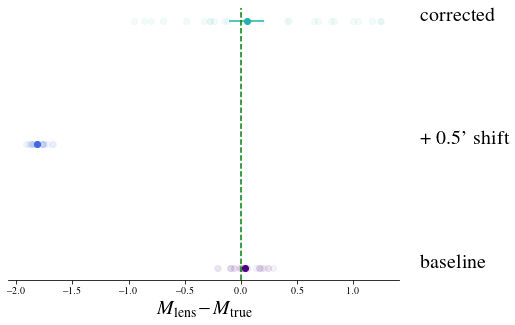

In [291]:
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_cluster_positions.npy', 'rb') as file:
    mass_arr = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_cluster_positions.npy', 'rb') as file:
    error_arr = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_comb_lk_cluster_positions.npy', 'rb') as file:
    mass_arr_comb_lk = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_comb_lk_cluster_positions.npy', 'rb') as file:
    error_arr_comb_lk = np.load(file) 

fig, ax = plt.subplots(figsize=(7,5))
centers_baseline = np.asarray(mass_arr[0])-2
centers_centroid_shift = np.asarray(mass_arr[1])-2
centers_centroid_shift_corrected = np.asarray(mass_arr[2])-2
centers = [centers_baseline, centers_centroid_shift, centers_centroid_shift_corrected]
width_arr = [error_arr[0], error_arr[1], error_arr[2]]
for cntr, (center, widthval, colorval) in enumerate(zip(centers, width_arr, color_arr )):
    yval = [cntr for i in range(len(center))]
   # plt.errorbar(center, yval, xerr = widthval, color = colorval, marker = 'o', ls = '', alpha = 0.02)
    plt.plot(center, yval, color = colorval, marker = 'o', ls = '', alpha = 0.05)
plt.errorbar(mass_arr_comb_lk[0]-2, 0, xerr = error_arr_comb_lk[0], color = color_arr[0],  marker = 'o', ls = '')
plt.errorbar(mass_arr_comb_lk[1]-2, 1, xerr = error_arr_comb_lk[1], color = color_arr[1], marker = 'o', ls = '')
plt.errorbar(mass_arr_comb_lk[2]-2, 2, xerr = error_arr_comb_lk[2], color = color_arr[2], marker = 'o', ls = '')
plt.axvline(0, color = 'green', ls = '--')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axes.yaxis.set_ticks([])
plt.text(1.6, 0, 'baseline', fontsize = sz_ft)
plt.text(1.6, 1, '+ 0.5\' shift', fontsize = sz_ft)
plt.text(1.6, 2, 'corrected', fontsize = sz_ft)
plt.xlabel(r'$M_{\rm lens}-M_{\rm true}$', fontsize = sz_ft)
plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/cluster_positions.svg', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)

## Foreground Bias

In [292]:
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, c200c1 = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
c200c2 = cosmo.concentration_parameter(M200c, 0.7, 0.674)
print(c200c1)
print(c200c2)

3.751849332385977
3.0254530417561614


In [293]:
c500 = concentration.concentration(2e14, '500c', 0.7)
M200c, _, _ = mass_defs.changeMassDefinition(2e14, c500, 0.7, '500c', '200c', profile='nfw')
cluster = [M200c, cosmo.concentration_parameter(M200c, 0.7, 0.674), 0.7] 
fname = '/Volumes/Extreme_SSD/codes/master_thesis/code/data/mdpl2_cutouts_for_tszksz_clus_detection_M1.7e+14to2.3e+14_z0.6to0.8_15320haloes_boxsize20.0am.npz'
cutouts_dic = np.load(fname, allow_pickle = 1, encoding= 'latin1')['arr_0'].item()
mass_z_key = list(cutouts_dic.keys())[0]
cutouts = cutouts_dic[mass_z_key]
scale_fac = fg.compton_y_to_delta_Tcmb(freq = 150, uK = True)
tsz_cutouts, ksz_cutouts, tsz_ksz_cutouts = [], [], []
for kcntr, keyname in enumerate( cutouts ):
    tsz_cutout = cutouts[keyname]['y']*scale_fac
    tsz_cutouts.append(tsz_cutout)
    ksz_cutout = cutouts[keyname]['ksz']*random.randrange(-1, 2, 2)
    ksz_cutouts.append(ksz_cutout)
    tsz_ksz_cutout = tsz_cutout + ksz_cutout
    tsz_ksz_cutouts.append(tsz_ksz_cutout) 
mass_int = np.arange(0, 4, 0.1) 

In [294]:
covariance_matrix_tsz, _ = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, cluster_corr_cutouts =  tsz_cutouts, bl = bl, nl = nl_arr[4], cl_noise = cl_noise_arr[4], correct_for_tsz = False)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_tsz.npy', covariance_matrix_tsz)
    
covariance_matrix_tsz_corrected, _ = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, cluster_corr_cutouts =  tsz_cutouts, bl = bl, nl = nl_arr[4], cl_noise = cl_noise_arr[4], correct_for_tsz = True)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_tsz_corrected.npy', covariance_matrix_tsz_corrected)

covariance_matrix_ksz, _ = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, cluster_corr_cutouts =  ksz_cutouts, bl = bl, nl = nl_arr[4], cl_noise = cl_noise_arr[4], correct_for_tsz = False)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_ksz.npy', covariance_matrix_ksz)
    
covariance_matrix_tsz_ksz, _ = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, cluster_corr_cutouts =  tsz_ksz_cutouts, bl = bl, nl = nl_arr[4], cl_noise = cl_noise_arr[4], correct_for_tsz = False)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_tsz_ksz.npy', covariance_matrix_tsz_ksz)
    
covariance_matrix_tsz_ksz_corrected, _ = lensing_estimator.covariance_and_correlation_matrix(nber_cov, nber_clus, map_params, l, cl, cluster_corr_cutouts =  tsz_ksz_cutouts, bl = bl, nl = nl_arr[4], cl_noise = cl_noise_arr[4], correct_for_tsz = True)
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_tsz_ksz_corrected.npy', covariance_matrix_tsz_ksz_corrected)    

  0%|          | 0/1000 [04:31<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
stack_bg = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/stack_bg_50000rand_2uK-arcmin.npy')   
covariance_matrix_baseline = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_3000clus_2uK-arcmin.npy')  
covariance_matrix_tsz = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_tsz.npy')  
covariance_matrix_tsz_corrected = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_tsz_corrected.npy')
covariance_matrix_ksz = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_ksz.npy')
covariance_matrix_tsz_ksz = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_tsz_ksz.npy')
covariance_matrix_tsz_ksz_corrected = np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/covariance_matrix_tsz_ksz_corrected.npy')
model_profiles =  np.load('/Volumes/Extreme_SSD/codes/master_thesis/code/results/model_profiles_2uK-arcmin.npy')    




lk_arr_baseline, mass_arr_baseline, error_arr_baseline = [], [], []      
lk_arr_tsz, mass_arr_tsz, error_arr_tsz = [], [], []      
lk_arr_ksz, mass_arr_ksz, error_arr_ksz = [], [], []  
lk_arr_tsz_ksz, mass_arr_tsz_ksz, error_arr_tsz_ksz = [], [], []
lk_arr_tsz_corrected, mass_arr_tsz_corrected, error_arr_tsz_corrected = [], [], []
lk_arr_tsz_ksz_corrected, mass_arr_tsz_ksz_corrected, error_arr_tsz_ksz_corrected = [], [], []
for i in tqdm(range(nber_runs)):    
    maps_clus_baseline, maps_clus_tsz, maps_clus_ksz, maps_clus_tsz_ksz = sims.cmb_test_data(map_params, l, cl, cluster = cluster, bl = bl, nl = nl_arr[4], nber_obs = nber_clus, foreground_bias = True)
    
    stack_clus_baseline = lensing_estimator.stack(map_params, maps_clus_baseline, l = l, cl = cl, cl_noise = cl_noise_arr[4])
    stack_clus_tsz, stack_tsz = lensing_estimator.stack(map_params, maps_clus_tsz, l = l, cl = cl, cl_noise = cl_noise_arr[4], correct_for_tsz = True)
    stack_clus_ksz = lensing_estimator.stack(map_params, maps_clus_ksz, l = l, cl = cl, cl_noise = cl_noise_arr[4])
    stack_clus_tsz_ksz, stack_tsz_ksz = lensing_estimator.stack(map_params, maps_clus_tsz_ksz, l = l, cl = cl, cl_noise = cl_noise_arr[4], correct_for_tsz = True)
    
    
    bins_baseline, lensing_dipole_profile_baseline, stack_dipole_baseline = lensing_estimator.lensing_dipole(map_params, stack_clus_baseline, stack_bg)
    bins_tsz, lensing_dipole_profile_tsz, stack_dipole_tsz = lensing_estimator.lensing_dipole(map_params, stack_clus_tsz, stack_bg)
    bins_tsz_corrected, lensing_dipole_profile_tsz_corrected, stack_dipole_tsz_corrected = lensing_estimator.lensing_dipole(map_params, stack_clus_tsz, stack_bg, stack_tsz = stack_tsz)
    bins_ksz, lensing_dipole_profile_ksz, stack_dipole_ksz = lensing_estimator.lensing_dipole(map_params, stack_clus_ksz, stack_bg)
    bins_tsz_ksz, lensing_dipole_profile_tsz_ksz, stack_dipole_tsz_ksz = lensing_estimator.lensing_dipole(map_params, stack_clus_tsz_ksz, stack_bg)
    bins_tsz_ksz_corrected, lensing_dipole_profile_tsz_ksz_corrected, stack_dipole_tsz_ksz_corrected = lensing_estimator.lensing_dipole(map_params, stack_clus_tsz_ksz, stack_bg, stack_tsz = stack_tsz_ksz)
    
    
    data_baseline = bins_baseline, lensing_dipole_profile_baseline, covariance_matrix_baseline
    data_tsz = bins_tsz, lensing_dipole_profile_tsz, covariance_matrix_tsz
    data_tsz_corrected = bins_tsz_corrected, lensing_dipole_profile_tsz_corrected, covariance_matrix_tsz_corrected
    data_ksz = bins_ksz, lensing_dipole_profile_ksz, covariance_matrix_ksz
    data_tsz_ksz = bins_tsz_ksz, lensing_dipole_profile_tsz_ksz, covariance_matrix_tsz_ksz
    data_tsz_ksz_corrected = bins_tsz_ksz_corrected, lensing_dipole_profile_tsz_ksz_corrected, covariance_matrix_tsz_ksz_corrected

    
    likelihood_baseline, mass_baseline, error_baseline = stats.run_ml(data_baseline, model_profiles, mass_int)
    mass_int_lk_baseline, lk_baseline = likelihood_baseline
    likelihood_tsz, mass_tsz, error_tsz = stats.run_ml(data_tsz, model_profiles, mass_int)
    mass_int_lk_tsz, lk_tsz = likelihood_tsz
    likelihood_tsz_corrected, mass_tsz_corrected, error_tsz_corrected = stats.run_ml(data_tsz_corrected, model_profiles, mass_int)
    mass_int_lk_tsz_corrected, lk_tsz_corrected = likelihood_tsz_corrected    
    likelihood_ksz, mass_ksz, error_ksz = stats.run_ml(data_ksz, model_profiles, mass_int)
    mass_int_lk_ksz, lk_ksz = likelihood_ksz
    likelihood_tsz_ksz, mass_tsz_ksz, error_tsz_ksz = stats.run_ml(data_tsz_ksz, model_profiles, mass_int)
    mass_int_lk_tsz_ksz, lk_tsz_ksz = likelihood_tsz_ksz
    likelihood_tsz_ksz_corrected, mass_tsz_ksz_corrected, error_tsz_ksz_corrected = stats.run_ml(data_tsz_ksz_corrected, model_profiles, mass_int)
    mass_int_lk_tsz_ksz_corrected, lk_tsz_ksz_corrected = likelihood_tsz_ksz_corrected
    
    
    lk_arr_baseline.append(lk_baseline)
    lk_arr_tsz.append(lk_tsz)
    lk_arr_tsz_corrected.append(lk_tsz_corrected)
    lk_arr_ksz.append(lk_ksz)
    lk_arr_tsz_ksz.append(lk_tsz_ksz)
    lk_arr_tsz_ksz_corrected.append(lk_tsz_ksz_corrected)
    
    mass_arr_baseline.append(mass_baseline)
    mass_arr_tsz.append(mass_tsz)
    mass_arr_tsz_corrected.append(mass_tsz_corrected)
    mass_arr_ksz.append(mass_ksz)
    mass_arr_tsz_ksz.append(mass_tsz_ksz)
    mass_arr_tsz_ksz_corrected.append(mass_tsz_ksz_corrected)

    error_arr_baseline.append(error_baseline)
    error_arr_tsz.append(error_tsz)
    error_arr_tsz_corrected.append(error_tsz_corrected)
    error_arr_ksz.append(error_ksz)
    error_arr_tsz_ksz.append(error_tsz_ksz)
    error_arr_tsz_ksz_corrected.append(error_tsz_ksz_corrected)
         
del maps_clus_baseline 
del maps_clus_tsz 
del maps_clus_ksz 
del maps_clus_tsz_ksz



mass_arr = [mass_arr_baseline, mass_arr_tsz, mass_arr_tsz_corrected, mass_arr_ksz, mass_arr_tsz_ksz, mass_arr_tsz, mass_arr_tsz_ksz_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_foreground_bias.npy', mass_arr)
error_arr = [error_arr_baseline, error_arr_tsz, error_arr_tsz_corrected, error_arr_ksz, error_arr_tsz_ksz, error_arr_tsz, error_arr_tsz_ksz_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_foreground_bias.npy', error_arr)
    
comb_lk_baseline, mass_comb_lk_baseline, error_comb_lk_baseline = stats.combined_likelihood(mass_int_lk_baseline, lk_arr_baseline)      
comb_lk_tsz, mass_comb_lk_tsz, error_comb_lk_tsz = stats.combined_likelihood(mass_int_lk_tsz, lk_arr_tsz)   
comb_lk_tsz_corrected, mass_comb_lk_tsz_corrected, error_comb_lk_tsz_corrected = stats.combined_likelihood(mass_int_lk_tsz_corrected, lk_arr_tsz_corrected)   
comb_lk_ksz, mass_comb_lk_ksz, error_comb_lk_ksz = stats.combined_likelihood(mass_int_lk_ksz, lk_arr_ksz)
comb_lk_tsz_ksz, mass_comb_lk_tsz_ksz, error_comb_lk_tsz_ksz = stats.combined_likelihood(mass_int_lk_tsz_ksz, lk_arr_tsz_ksz)   
comb_lk_tsz_ksz_corrected, mass_comb_lk_tsz_ksz_corrected, error_comb_lk_tsz_ksz_corrected = stats.combined_likelihood(mass_int_lk_tsz_ksz_corrected, lk_arr_tsz_ksz_corrected)   


mass_arr_comb_lk = [mass_comb_lk_baseline, mass_comb_lk_tsz, mass_comb_lk_tsz_corrected, mass_comb_lk_ksz, mass_comb_lk_tsz_ksz, mass_comb_lk_tsz_ksz_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_comb_lk_foreground_bias.npy', mass_arr_comb_lk)
error_arr_comb_lk = [error_comb_lk_baseline, error_comb_lk_tsz, error_comb_lk_tsz_corrected, error_comb_lk_ksz, error_comb_lk_tsz_ksz, error_comb_lk_tsz_ksz_corrected]
np.save('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_comb_lk_foreground_bias.npy', error_arr_comb_lk)  


bias = (mass_comb_lk_tsz-(M200c*1e-14))/(M200c*1e-14)
inc_err_frac_tsz = error_comb_lk_tsz/error_comb_lk_baseline
inc_err_frac_tsz_corrected = error_comb_lk_tsz_corrected/error_comb_lk_baseline
inc_err_frac_ksz = error_comb_lk_ksz/error_comb_lk_baseline
inc_err_frac_tsz_ksz = error_comb_lk_tsz_ksz/error_comb_lk_baseline
inc_err_frac_tsz_ksz_corrected = error_comb_lk_tsz_ksz_corrected/error_comb_lk_baseline
result = "{0:11.3f}".format(bias)+'\n'
result+= "{0:11.3f}".format(inc_err_frac_tsz)+'\n'
result+= "{0:11.3f}".format(inc_err_frac_tsz_corrected)+'\n'
result+= "{0:11.3f}".format(inc_err_frac_ksz)+'\n'
result+= "{0:11.3f}".format(inc_err_frac_tsz_ksz)+'\n'
result+= "{0:11.3f}".format(inc_err_frac_tsz_ksz_corrected)
file = open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/bias_result_foreground_bias.txt',"w")
file.write(result)
file.close() 

In [ ]:
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_foreground_bias.npy', 'rb') as file:
    mass_arr = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_foreground_bias.npy', 'rb') as file:
    error_arr = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/mass_arr_comb_lk_foreground_bias.npy', 'rb') as file:
    mass_arr_comb_lk = np.load(file) 
    
with open('/Volumes/Extreme_SSD/codes/master_thesis/code/results/error_arr_comb_lk_foreground_bias.npy', 'rb') as file:
    error_arr_comb_lk = np.load(file) 

    
fig, ax = plt.subplots(figsize=(7,5))
centers_baseline = np.asarray(mass_arr[0])-M200c*1e-14
centers_tsz = np.asarray(mass_arr[1])-M200c
centers_tsz_corrected = np.asarray(mass_arr[2])M200c*1e-14
centers_ksz = np.asarray(mass_arr[3])-M200c*1e-14
centers_tsz_ksz = np.asarray(mass_arr[4])-M200c*1e-14
centers_tsz_ksz_corrected = np.asarray(mass_arr[5])-M200c*1e-14
centers = [centers_baseline, centers_tsz , centers_tsz_corrected, centers_ksz , centers_tsz_ksz, centers_tsz_ksz_corrected]
width_arr = [error_arr[0], error_arr[1], error_arr[2], error_arr[3], error_arr[4], error_arr[5], error_arr[6]]
for cntr, (center, widthval, colorval) in enumerate(zip(centers, width_arr, color_arr )):
    yval = [cntr for i in range(len(center))]
    plt.errorbar(center, yval, xerr = widthval, color = colorval, marker = 'o', ls = '', alpha = 0.05)
plt.errorbar(mass_arr_comb_lk[0]-M200c, 0, xerr = error_arr_comb_lk[0], color = color_arr[0], marker = 'o', ls = '')
plt.errorbar(mass_arr_comb_lk[1]-M200c, 1, xerr = error_arr_comb_lk[1], color = color_arr[1], marker = 'o', ls = '')
plt.errorbar(mass_arr_comb_lk[2]-M200c, 2, xerr = error_arr_comb_lk[2], color = color_arr[2], marker = 'o', ls = '')
plt.errorbar(mass_arr_comb_lk[3]-M200c, 0, xerr = error_arr_comb_lk[3], color = color_arr[3], marker = 'o', ls = '')
plt.errorbar(mass_arr_comb_lk[4]-M200c, 1, xerr = error_arr_comb_lk[4], color = color_arr[4], marker = 'o', ls = '')
plt.errorbar(mass_arr_comb_lk[5]-M200c, 2, xerr = error_arr_comb_lk[5], color = color_arr[5], marker = 'o', ls = '')
plt.axvline(0, color = 'green', ls = '--')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axes.yaxis.set_ticks([])
plt.text(0.42, 0, 'baseline', fontsize = sz_ft)
plt.text(0.42, 1, 'with tSZ', fontsize = sz_ft)
plt.text(0.42, 2, 'with kSZ', fontsize = sz_ft)
plt.text(0.42, 3, 'with tSZ and kSZ', fontsize = sz_ft)
plt.text(0.42, 4, 'tSZ corrected', fontsize = sz_ft)
plt.text(0.42, 5, 'tSZ and kSZ corrected', fontsize = sz_ft)
plt.xlabel(r'$M_{lens}-M_{true}$', fontsize = sz_ft)
plt.savefig('/Volumes/Extreme_SSD/codes/master_thesis/code/figures/foreground_bias.eps', dpi = 200., bbox_inches = 'tight', pad_inches = 0.1)